# Orient Express &ndash; Delay modeling

In [1]:
%%configure -f
{"conf":{"spark.app.name": "orientexpress"},
 "driverMemory": "4g",
 "executorMemory": "8g",
 "executorCores": 25, 
 "numExecutors": 9, 
 "kind": "pyspark"
}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
8875,application_1589299642358_3407,pyspark,idle,Link,Link,
8880,application_1589299642358_3412,pyspark,idle,Link,Link,
8883,application_1589299642358_3415,pyspark,idle,Link,Link,
8885,application_1589299642358_3417,pyspark,busy,Link,Link,
8888,application_1589299642358_3420,pyspark,busy,Link,Link,
8889,application_1589299642358_3421,pyspark,idle,Link,Link,
8891,application_1589299642358_3423,pyspark,busy,Link,Link,
8895,application_1589299642358_3427,pyspark,idle,Link,Link,
8896,application_1589299642358_3428,pyspark,idle,Link,Link,
8897,application_1589299642358_3429,pyspark,busy,Link,Link,


In [2]:
import pyspark.sql.functions as F

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
8925,application_1589299642358_3457,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%%local 
import matplotlib.pyplot as plt

## 1. Load & filter actual data

In [4]:
def compute_delay():
        
    df = spark.read.csv('/data/sbb/istdaten/*/*/*.csv.bz2', sep=';', header=True)
    df = df.selectExpr("BETRIEBSTAG as date", 
                             "FAHRT_BEZEICHNER as trip_id",
                             "BETREIBER_ID as operator_id",
                             "BETREIBER_ABK as operator_ab",
                             "BETREIBER_NAME as operator_name", 
                             "PRODUKT_ID as transport_type",
                             "LINIEN_ID as train_id", 
                             "LINIEN_TEXT as train_type", 
                             "UMLAUF_ID as circulation_id",
                             "VERKEHRSMITTEL_TEXT as train_type2", 
                             "ZUSATZFAHRT_TF as additional_trip",
                             "FAELLT_AUS_TF as trip_failed", 
                             "BPUIC as bpuic", 
                             "HALTESTELLEN_NAME as stop_name",
                             "ANKUNFTSZEIT as arrival_schedule", 
                             "ABFAHRTSZEIT as departure_schedule",
                             "AN_PROGNOSE as arrival_actual",
                             "AB_PROGNOSE as departure_actual",
                             "AN_PROGNOSE_STATUS as arrival_status",
                             "AB_PROGNOSE_STATUS as departure_status",
                             "DURCHFAHRT_TF as does_not_stop")
    
    # Keep only stops which are with a 15 km radius around Zürich HB
    stop_path = "/user/tvaucher/stops"
    
    stop_names = spark.read.parquet(stop_path).select('stop_name').distinct()

    df = df.join(stop_names, ['stop_name']).cache()
    
    # convert to unix timestamp
    df = df.withColumn('arrival_schedule', F.unix_timestamp('arrival_schedule', 'dd.MM.yyy HH:mm'))
    df = df.withColumn('arrival_actual', F.unix_timestamp('arrival_actual', 'dd.MM.yyy HH:mm:ss'))
    
    # compute arrival delays
    df = df.withColumn('arrival_delay', F.col('arrival_actual') - F.col('arrival_schedule'))
    
    # reformat the arrival columns
    df = df.withColumn('arrival_schedule', F.from_unixtime('arrival_schedule'))
    df = df.withColumn('arrival_actual', F.from_unixtime('arrival_actual'))
    
    # remove rows where arrival is null -6% of DF (13'478'468 rows)
    df = df.where(~(F.col("arrival_actual").isNull() | F.col("arrival_schedule").isNull()))
    
    # keep only day of the week (remove Saturdays:7 and Sundays:1)
    df = df.where(~(F.dayofweek(F.from_unixtime(F.unix_timestamp('date', 'dd.MM.yyy'))).isin(['7', '1'])))
    
    # keep only transports arriving between 7 and 19
    df = df.where((F.hour('arrival_schedule') >= '07') & (F.hour('arrival_schedule') <= '18'))
    
    # remove rows for which we don't have transport_type -0.001 % of DF (1'042 rows)
    df = df.where(~ (F.col('transport_type').isNull()))
    
    # remove rows when transport does not stop -0.04% of DF (33'992 rows)
    df = df.where(F.col('does_not_stop')=='false')
    
    # remove data after dec 16 2019 (schedule change at CFF)
    df = df.where(F.from_unixtime(F.unix_timestamp('date', 'dd.MM.yyy')) <= "2019-12-15")
    
    # put all negative delay to zero - we don't care about train arriving ahead of schedule
    df = df.withColumn('arrival_delay', F.when(F.col('arrival_delay') >= 0, F.col('arrival_delay')).otherwise(0))
    
    # change BUS to Bus
    df = df.withColumn('transport_type', F.when(F.col('transport_type') == 'BUS', 'Bus')\
                       .otherwise(F.col('transport_type')))
    
    # manually remove entries which have been found as not regular 
    df = df.where(~((F.col('stop_name')=='Zürich, Friedrichstrasse') & (F.col('transport_type')=='Tram'))
                 & ~((F.col('stop_name')=='Zürich, Frohburg') & (F.col('transport_type')=='Tram'))
                 & ~((F.col('stop_name')=='Zürich, Letzigrund') & (F.col('transport_type')=='Bus'))
                 & ~((F.col('stop_name')=='Zürich, Im Klösterli') & (F.col('transport_type')=='Bus'))
                 & ~((F.col('stop_name')=='Zürich, Brunaustrasse') & (F.col('transport_type')=='Bus'))
                 & ~((F.col('stop_name')=='Zürich, Museum Rietberg') & (F.col('transport_type')=='Bus'))
                 & ~((F.col('stop_name')=='Zürich, Billoweg') & (F.col('transport_type')=='Bus'))
                 & ~((F.col('stop_name')=='Zürich, Strickhof') & (F.col('transport_type')=='Bus'))
                )

    # add indication on time of the day
    df = df.withColumn('timeframe', 
              F.when(F.date_format('arrival_schedule', 'HH:mm:ss') < '09:30:00', 'morning')
              .when(F.date_format('arrival_schedule', 'HH:mm:ss') > '16:00:00', 'evening')
                       .otherwise('day'))
    
    return df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
df = compute_delay().cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. Statistical analysis

In this section, we consider the different possible groupings for delay parameters. In particular, we study the variation in delay, and the amount of data available based on 3 factors: transport type, time of day and stop ID.

We use the statistical differences to justify how we calculate different parameters when estimating delay distributions.

### 2.1 Transport type

We consider the major transport types -- trains, trams and buses.

In [6]:
group_transport = df.groupBy('transport_type').agg(F.mean('arrival_delay').alias('avg_delay'), F.count(F.lit(1)).alias('n_rows'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
group_transport.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----------------+--------+
|transport_type|        avg_delay|  n_rows|
+--------------+-----------------+--------+
|          Tram|68.21081143278012|29348802|
|           Zug|73.83894200135794| 5359591|
|           Bus|98.10742573387249|63091717|
+--------------+-----------------+--------+

In [8]:
%%spark -o group_transport

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

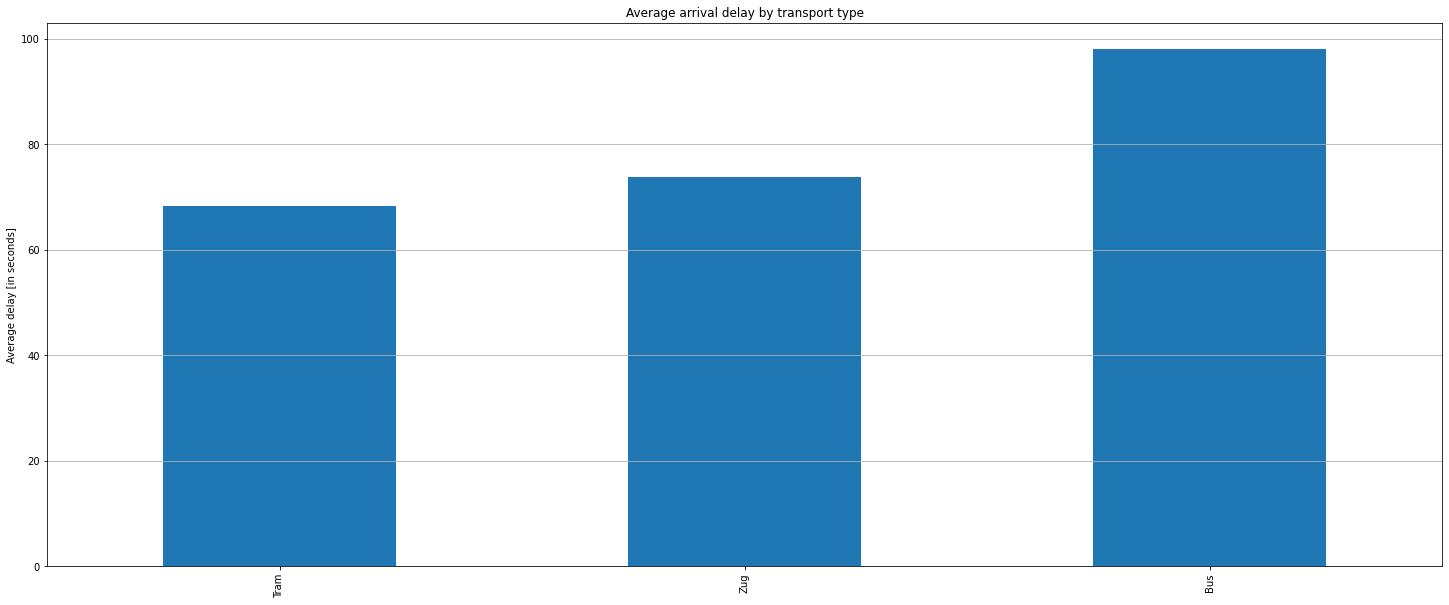

In [9]:
%%local 
# plot to visualise
fig, ax = plt.subplots(figsize=(25, 10))
group_transport['avg_delay'].plot.bar(ax=ax)
ax.set_title('Average arrival delay by transport type')
ax.set_ylabel('Average delay [in seconds]')
plt.xticks(range(len(group_transport)), group_transport.transport_type)
plt.rc('axes', labelsize=12) 
plt.rc('font', size=18) 
plt.grid(axis='y')

plt.show()

In the table and graph displayed above, we can see that we have a significant number of data points for each of the three transport types. In addition to that, we can clearly see that transport types have a different delay average. In particular,  buses have a larger delay on average (~1'40'', against 1'13'' and 1'08'' for trains and trams respectively). It is clear that it would be beneficial to have separate delay parameters based on transport type at the very least.

We know from experience that some train types (RE, IC, EC, etc.) tend to be more reliable than others in terms of timing, so we decided to further look into the more popular train types to see if there is a significant difference in average delays for them.

In [10]:
group_trains = df.where(F.col('transport_type')=='Zug').groupBy('train_type2').agg(F.mean('arrival_delay').alias('avg_delay'), F.count(F.lit(1)).alias('n_rows'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
group_trains.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+-------+
|train_type2|         avg_delay| n_rows|
+-----------+------------------+-------+
|         IC|  88.6034583903679| 107391|
|        ZUG|             208.4|      5|
|         RE| 64.72833235526235|  49417|
|         NJ| 698.8461007591443|   1449|
|        TGV|421.07397260273973|   1460|
|         EN|382.55555555555554|     18|
|         EC| 257.5833075255497|   6458|
|         IR| 79.50516298247894| 169282|
|          D|             223.5|      4|
|        ICE|261.30493678506923|   3322|
|         AG|             460.0|      4|
|          S|  72.6010765897149|5016953|
|        EXT| 75.00530222693531|   1886|
|        RJX| 506.4327176781003|    758|
|          P|             210.5|      2|
|         RJ| 543.8535139712109|   1181|
|         MP|              19.0|      1|
+-----------+------------------+-------+

In [12]:
%%spark -o group_trains

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
%%local 
# we consider the more popular train types
sub_group_trains = group_trains.loc[group_trains.train_type2.isin(['IC', 'RE', 'TGV', 'EC', 'IR', 'ICE', 'S'])]

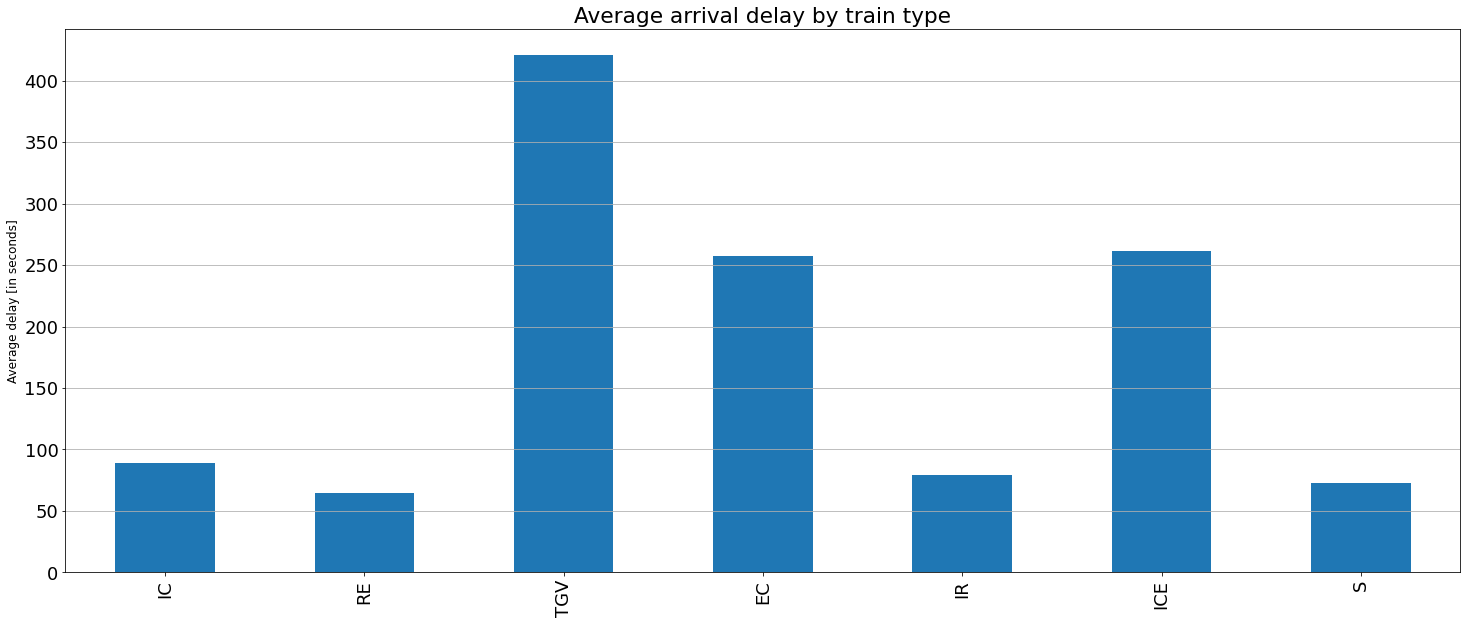

In [14]:
%%local 
# plot to visualise
fig, ax = plt.subplots(figsize=(25, 10))
sub_group_trains['avg_delay'].plot.bar(ax=ax)
ax.set_title('Average arrival delay by train type')
ax.set_ylabel('Average delay [in seconds]')
plt.xticks(range(len(sub_group_trains)), sub_group_trains.train_type2)
plt.rc('axes', labelsize=12) 
plt.rc('font', size=18) 
plt.grid(axis='y')

plt.show()

We can see a very clear difference in average arrival delay based on train type. It seems that more long distance trains, such as EC, TGV and ICE all have much greater delays than the other train types do. We will thus use specific parameters for each of these train types, instead of the average train delay.

Some types are not shown here, such as ZUG or EN, because we don't have enough entries on these. Also we do not consider some lines which we found not very relevant, such as NJ which are supposed to be night trains.

### 2.2 Time of day

We wanted to see how the delay varies with time of day for various transports. We display these variations below:

In [15]:
hour_delay = df.withColumn('hour', F.hour('arrival_schedule')).groupBy('hour').agg(F.mean('arrival_delay').alias('avg_delay'), F.count(F.lit(1)).alias('n_rows')).orderBy('hour')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
%%spark -o hour_delay

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

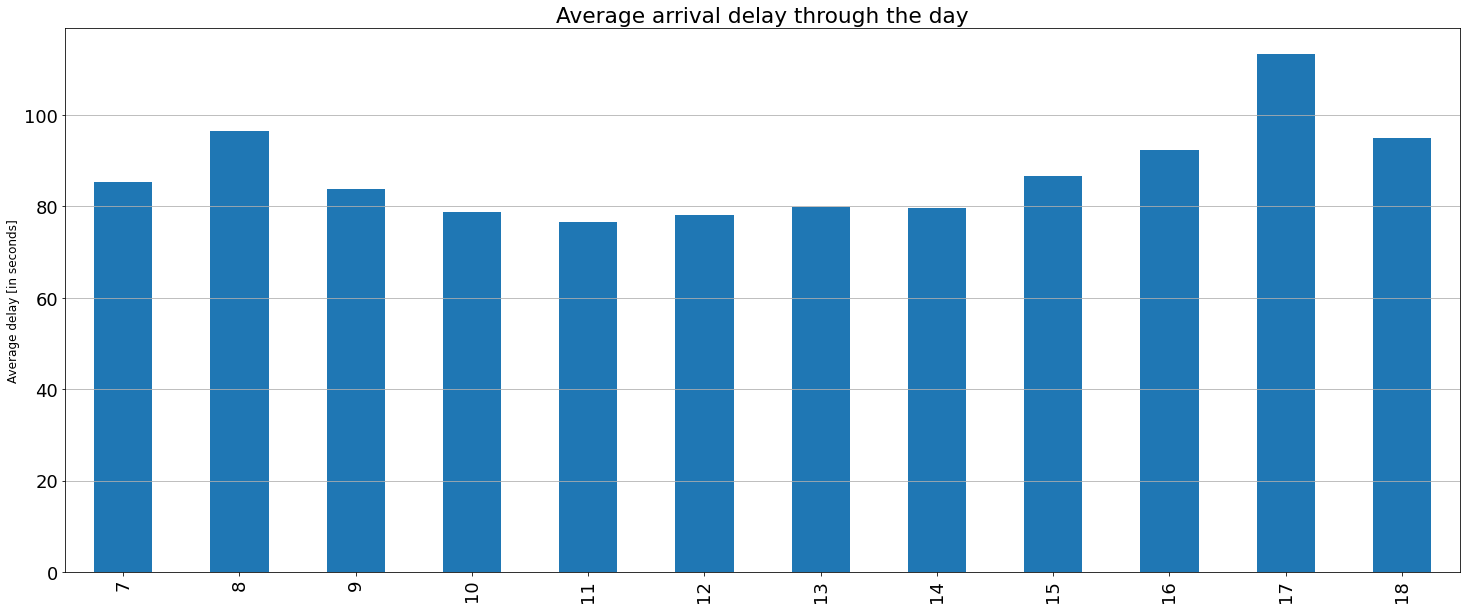

In [17]:
%%local 
# plot to visualise
fig, ax = plt.subplots(figsize=(25, 10))
hour_delay['avg_delay'].plot.bar(ax=ax)
ax.set_title('Average arrival delay through the day')
ax.set_ylabel('Average delay [in seconds]')
plt.xticks(range(len(hour_delay)), hour_delay.hour)
plt.rc('axes', labelsize=12) 
plt.rc('font', size=18) 
plt.grid(axis='y')

plt.show()

We can clearly see the two peak delay sections that correspond to peak commute times, as well as a reduction in delays in the middle of the day, most likely due to a reduction in traffic congestion. Since we are able to easily identify three distinct categories, we split our time-based factors into three categories:

- morning: 7:00 - 9:30
- day: 9:30 - 16:00
- evening: 16:00 - 19:00

We can use these categories to estimate parameters, in addition to those previously identified.

In [18]:
group_timeframe = df.groupBy('timeframe').agg(F.mean('arrival_delay').alias('avg_delay'), F.count(F.lit(1)).alias('n_rows'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
%%spark -o group_timeframe

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

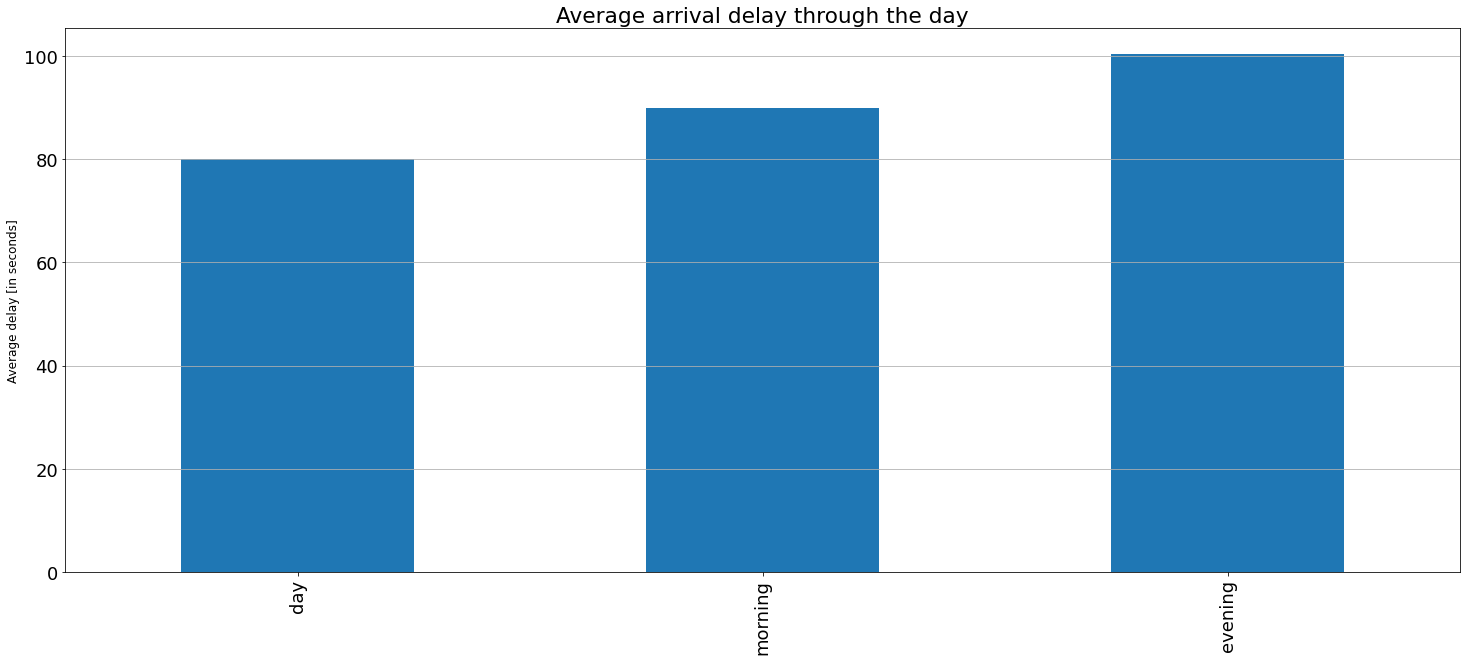

In [20]:
%%local 
# plot to visualise
fig, ax = plt.subplots(figsize=(25, 10))
group_timeframe['avg_delay'].plot.bar(ax=ax)
ax.set_title('Average arrival delay through the day')
ax.set_ylabel('Average delay [in seconds]')
plt.xticks(range(len(group_timeframe)), group_timeframe.timeframe)
plt.rc('axes', labelsize=12) 
plt.rc('font', size=18) 
plt.grid(axis='y')

plt.show()

We can see that based on the identified categories, the peak average delay takes place during the evening commute time, followed by morning commute time and then finally the middle of the day. These delays are each separated by approximately 10 seconds, making the time of day an important factor to consider when estimating the delay for a trip.

### 2.3 Stops

In addition to considering type of transport and time of day, we consider each stop separately. All stops have their own particularities, and for those stops that have a sufficient number of data points, we are more likely to be precise when modeling based on the stop, rather than just transport type. We consider the variation amongst stops:

In [25]:
group_stop = df.groupBy('stop_name').agg(F.mean('arrival_delay').alias('avg_delay'), F.count(F.lit(1)).alias('n_rows'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
group_stop.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+------+
|           stop_name|         avg_delay|n_rows|
+--------------------+------------------+------+
|Zürich, Stockerst...|   67.827428466926|404638|
|Zürich, Tunnelstr...| 68.75269300108425|311734|
|Zürich, Schmiede ...| 80.22926490984743|490280|
| Zürich, Oerlikerhus|  74.2413742017069|188997|
|Zürich Flughafen,...| 91.45778780581581|395336|
|  Kloten, Kirchgasse| 96.73094016659894| 78752|
|Wangen, Flugsiche...| 95.64189235990857| 43311|
|Erlenbach ZH, Im ...| 183.7195821508363| 16561|
|    Zürich, Klosbach| 96.39935524785963| 94610|
| Zürich, Schauenberg|62.552539777078195| 23506|
|     Zürich, Althoos| 84.21385605518866| 47546|
|Rüschlikon, Weids...| 91.38660993081491| 32666|
|  Urdorf, Oberurdorf|105.39903699174565| 26168|
|      Uitikon, Halde|100.94152512384997| 22608|
|  Zürich, EPI-Klinik| 75.25731644526826| 48555|
| Winkel am Zürichsee| 89.97462806085893| 47454|
|Zürich, Saalsport...| 82.93934621254056|326987|
|  Zürich, Fischerwe

In [27]:
%%spark -o group_stop

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

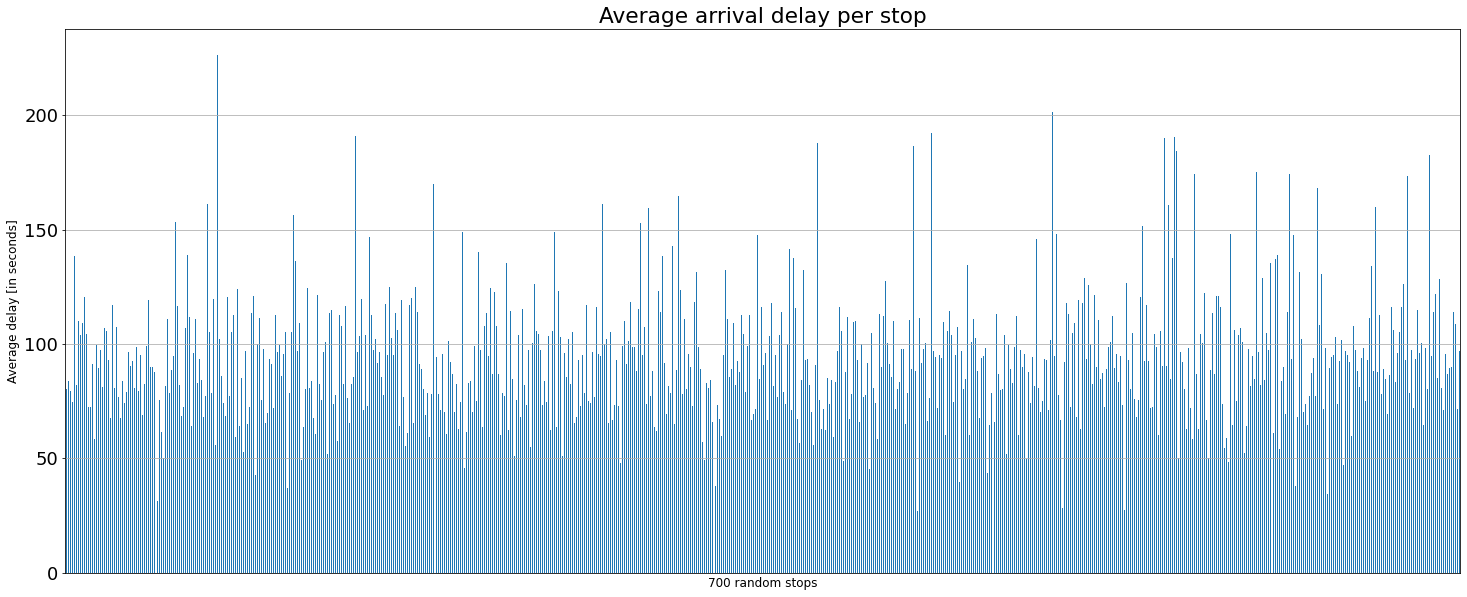

In [29]:
%%local 
# plot to visualise
fig, ax = plt.subplots(figsize=(25, 10))
group_stop['avg_delay'].sample(n=700, random_state=0).plot.bar(ax=ax)
ax.set_title('Average arrival delay per stop')
ax.set_xlabel('700 random stops')
ax.set_ylabel('Average delay [in seconds]')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.rc('axes', labelsize=12) 
plt.rc('font', size=18) 
plt.grid(axis='y')

plt.show()

As we can see, having taken a sample of 700 random stops (for displaying purposes), there is a significant variety in average delay amongst stops -- potentially based on whether they're located in congested areas or on hills that are difficult to ride up, or if they are at the end of a long trip for example. It is certainly interesting to consider taking into account a stop-specific delay parameter.

Thus, based on the analysis performed above, we deduce that we can maximize the performance of our probability distribution estimator by having a parameter that takes into account (in order of priority):
1. stop name (the largest disparity between stops)
2. time of day (morning, day, evening)
3. transport type (with specific parameters for the most popular trains)

## 3. Save identified categories

We create a delay table, based on the groupings that we identified:
- `tram_delays`: delay for each tram stop, each with a distinct parameter based on time of day (morning, day, evening)
- `bus_delays_without_time`: delay for each bus stop, not taking into consideration time
- `bus_delays`: delay for each bus stop, each with a distinct parameter based on time of day (morning, day, evening)
- `train_delays`: delay for each train stop, based on train type (IC, ER, IR, etc.) and with a distinct parameter based on time of day (morning, day, evening)
- `train_delays_without_type`: delay for each train stop, not taking into consideration train type (IC, ER, IR, etc.), but each with a distinct parameter based on time of day (morning, day, evening)
- `overal_delay`: overall average delay, used as the default parameter for the delay

In [32]:
tram_delays = df.where(F.col('transport_type')=='Tram').groupBy(['stop_name', 'timeframe']).agg(F.mean('arrival_delay').alias('avg_delay'), F.count(F.lit(1)).alias('n_rows'))
bus_delays_without_time = df.where(F.col('transport_type')=='Bus').groupBy(['stop_name']).agg(F.mean('arrival_delay').alias('avg_delay'), F.count(F.lit(1)).alias('n_rows'))
bus_delays = df.where(F.col('transport_type')=='Bus').groupBy(['stop_name', 'timeframe']).agg(F.mean('arrival_delay').alias('avg_delay'), F.count(F.lit(1)).alias('n_rows'))
train_delays = df.where(F.col('transport_type')=='Zug').groupBy(['stop_name', 'timeframe', 'train_type2']).agg(F.mean('arrival_delay').alias('avg_delay'), F.count(F.lit(1)).alias('n_rows'))
train_delays_without_type = df.where(F.col('transport_type')=='Zug').groupBy(['stop_name', 'timeframe']).agg(F.mean('arrival_delay').alias('avg_delay'), F.count(F.lit(1)).alias('n_rows'))
overal_delay = df.agg(F.mean('arrival_delay').alias('avg_delay'), F.count(F.lit(1)).alias('n_rows'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
df.write.parquet('/user/jjgweber/delays_df', mode='overwrite', compression='gzip')
tram_delays.write.parquet('/user/jjgweber/tram_delays', mode='overwrite', compression='gzip')
bus_delays.write.parquet('/user/jjgweber/bus_delays', mode='overwrite', compression='gzip')
bus_delays_without_time.write.parquet('/user/jjgweber/bus_delays_without_time', mode='overwrite', compression='gzip')
train_delays.write.parquet('/user/jjgweber/train_delays', mode='overwrite', compression='gzip')
train_delays_without_type.write.parquet('/user/jjgweber/train_delays_without_type', mode='overwrite', compression='gzip')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…